In [1]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'Training_Pusher_by_DQN/DQN'

%cd /content/drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/Training_Pusher_by_DQN/DQN


In [2]:
! pip install gymnasium[mujoco]==0.29.1 tensorflow==2.15.0 dill
# pusher-v4에서 mujoco>=3.0.0을 쓰면 물체에 fingertip이 닿지 않고 뚫고 지나감
! pip install mujoco==2.3.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 108.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 22.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully unin

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import gymnasium as gym
from collections import deque, Counter
import random
import dill as pickle
import matplotlib.pyplot as plt

In [4]:
# 물건 닿지 않는 에러 해결 위해
DEFAULT_CAMERA_CONFIG = {
    'trackbodyid': -1,
    'distance': 3.0,
    'azimuth': 135.0,
    'elevation': -22.5,
}

env = gym.make("Pusher-v4", render_mode="rgb_array")
env.unwrapped.mujoco_renderer.default_cam_config = DEFAULT_CAMERA_CONFIG

n_outputs = 14

In [5]:
eps_min = 0.3
eps_max = 0.5
eps_decay_steps = 100000

def epsilon_greedy(action, step):
  epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
  if np.random.rand() < epsilon:
    return np.array([np.random.randint(0,n_outputs)])
  else:
    return action

In [6]:
buffer_len = 20000
exp_buffer = deque(maxlen=buffer_len)

In [7]:
def sample_memories(batch_size):
    perm_batch = np.random.permutation(len(exp_buffer))[:batch_size]
    #포인터로 저장
    mem = np.array(exp_buffer,dtype=object)[perm_batch]
    return mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]

In [8]:
# A larger batch size can reduce the variance in the gradient updates.
batch_size = 100
learning_rate = 0.001
X_shape = (None, 23)
discount_factor = 0.97

# 이 env는 항상 100step 돌고 끝남
one_episode_period=100
global_step = 0
copy_steps = 20
# one_episode_period(100)을 나눠떨어지게 하는 수로 해야 episode당 학습수 동일해서 episodic loss가 의미있어짐
steps_train = 4
# n번째 에피소드부터 학습, copy 시작
episode_to_start_train=5
start_steps = one_episode_period*(episode_to_start_train-1)

# train 결과 몇 개 episode 완료할 때마다 평균내서 출력할지
period_print_result=10

In [9]:
class DQN(Model):

    def __init__(self, action_n):
        super(DQN, self).__init__()

        self.h5 = Dense(224, activation='relu')
        self.h6 = Dense(112, activation='relu')
        self.h7 = Dense(56, activation='relu')
        self.h8 = Dense(28, activation='relu')
        self.q = Dense(action_n, activation='linear')


    def call(self, x):
        x = self.h5(x)
        x = self.h6(x)
        x = self.h7(x)
        x = self.h8(x)
        q = self.q(x)
        return q


dqn = DQN(n_outputs)
target_dqn = DQN(n_outputs)

dqn.build(input_shape=X_shape)
target_dqn.build(input_shape=X_shape)

dqn_opt = Adam(learning_rate)

dqn.summary()


## computing TD target: y_k = r_k + gamma* max Q(s_k+1, a)
def compute_td_target(rewards, target_qs):
  max_q = np.max(target_qs, axis=1, keepdims=True)
  y_k = np.zeros(max_q.shape)
  for i in range(max_q.shape[0]): # number of batch
    y_k[i] = rewards[i] + discount_factor * max_q[i]
  return y_k


def dqn_learn(states, actions, td_targets):
  with tf.GradientTape() as tape:
      one_hot_actions = tf.one_hot(actions, n_outputs)
      q = dqn(states, training=True)
      q_values = tf.reduce_sum(one_hot_actions * q, axis=1, keepdims=True)
      loss = tf.reduce_mean(tf.square(q_values-td_targets))
  grads = tape.gradient(loss, dqn.trainable_variables)
  dqn_opt.apply_gradients(zip(grads, dqn.trainable_variables))
  return loss.numpy()


def update_target_network():
  weights = dqn.get_weights()
  target_dqn.set_weights(weights)


# 0~13 형태의 action을, env를 위해 앞 원소부터 1, -1 하고 다음 원소로 넘어가는 식으로 (1,0,0,0,0,0,0)~(0,0,0,0,0,0,-1) 형태로 변환
def change_action_format(action):
  action=action[0]
  action_type=action//2
  action_sign=action%2
  list=np.zeros(shape=(7,),dtype=np.float32)
  if action_sign:
    list[action_type]=-1.0
  else:
    list[action_type]=1.0
  return list

def test(test_reward_list):
  done = False
  # obs는 shape (23,) numpy array
  obs,_ = env.reset()
  episodic_reward = 0
  actions_counter = Counter()

  while not done:

    # actions shape (batch,14) numpy array
    actions = dqn(tf.convert_to_tensor([obs], dtype=tf.float32))

    # action shape (1,) numpy array
    action = np.argmax(actions, axis=-1)

    actions_counter[action[0]] += 1

    # action env에 맞춰 list로 변환
    action_env=change_action_format(action)

    next_obs,reward,terminated,truncated,_ = env.step(action_env)

    done= terminated or truncated

    obs = next_obs
    episodic_reward += reward

  print('gloabl step', global_step, 'Test Reward', episodic_reward)
  print('Test', actions_counter)
  test_reward_list.append(episodic_reward)

Model: "dqn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  5376      
                                                                 
 dense_1 (Dense)             multiple                  25200     
                                                                 
 dense_2 (Dense)             multiple                  6328      
                                                                 
 dense_3 (Dense)             multiple                  1596      
                                                                 
 dense_4 (Dense)             multiple                  406       
                                                                 
Total params: 38906 (151.98 KB)
Trainable params: 38906 (151.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
# 아래 렌더링에 필요한 패키지들
!apt-get install -y xvfb x11-utils
!pip install PyOpenGL
!pip install PyOpenGL-accelerate
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install pyvirtualdisplay

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 libxtst6 libxxf86dga1 x11-xkb-utils xfonts-base
  xfonts-encodings xfonts-utils xserver-common
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 libxtst6 libxxf86dga1 x11-utils x11-xkb-utils xfonts-base
  xfonts-encodings xfonts-utils xserver-common xvfb
0 upgraded, 12 newly installed, 0 to remove and 49 not upgraded.
Need to get 8,046 kB of archives.
After this operation, 12.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.

In [11]:
# 훈련 완료 후 이어서 1번의 에피소드로 테스트할 때, 이를 녹화하고자
from gymnasium.wrappers import RecordVideo
# 코랩에서 가상 디스플레이 생성. 렌더링하고 녹화할 곳이 필요.
from pyvirtualdisplay import Display

def test_and_render(num_trial):
  _display = Display(visible=False, size=(1400, 900))
  _ = _display.start()

  # 아래 기술된 대로 폴더를 준비해둬야 에러 발생x (현 디렉토리 맨 위 셀 참고)
  env1 = RecordVideo(env, video_folder="./비디오/newcamera_target_network_5layer")

  for i in range(num_trial):
    r=0
    state,_=env1.reset()
    actions_counter = Counter()

    while True:
      env1.render()

      actions = dqn(tf.convert_to_tensor([state], dtype=tf.float32))
      action = np.argmax(actions, axis=-1)
      action_env=change_action_format(action)

      actions_counter[action[0]] += 1


      nextstate,reward,terminated,truncated,info = env1.step(action_env)

      state=nextstate
      r+=reward

      done=terminated or truncated

      if done:
          print(f'total reward of the episode : {r:6.3f}')
          print(actions_counter)
          break
  env1.close()
  _display.stop()

In [12]:
# 불러오기 (새로운 모델 학습시킬 때 주석 처리)
# 아래 기술된 대로 폴더와 파일을 준비해둬야 에러 발생x (현 디렉토리 맨 위 셀 참고)
with open('./피클/newcamera_target_network_5layer/test_reward_list.p','rb') as f:
  test_reward_list=pickle.load(f)
with open('./피클/newcamera_target_network_5layer/episodic_loss_list.p','rb') as f:
  episodic_loss_list=pickle.load(f)

dqn.load_weights('./모델 weights/newcamera_target_network_5layer/save_weights')

# 초기화 (새로운 모델 학습시킬 때 주석 해제)
'''test_reward_list=[ ]
episodic_loss_list=[]'''

'test_reward_list=[ ]\nepisodic_loss_list=[]'

In [13]:
# 한번에 학습시키고 싶은 만큼 유동적으로
num_episodes = 30

global_step=0

# for each episode
for i in range(num_episodes):

  if i%20 == 0:
    # train 중에는 epsilon-greedy 때문에 reward가 능력에 비해 더 떨어질 수밖에 없음
    # 그래서 epsilon-greedy 없는 상태로 reward를 구해봄
    test(test_reward_list)

  done = False
  # obs는 shape (23,) numpy array
  obs,_ = env.reset()
  epoch = 0
  episodic_loss = 0

  while not done:

    # actions shape (batch,14) numpy array
    actions = dqn(tf.convert_to_tensor([obs], dtype=tf.float32))
    # action shape (1,) numpy array
    action = np.argmax(actions.numpy(), axis=-1)

    action = epsilon_greedy(action, global_step)

    # action을 env에 맞춰 shape (7,)로 변환
    action_env=change_action_format(action)

    next_obs,reward,terminated,truncated,info = env.step(action_env)

    done= terminated or truncated

    exp_buffer.append([obs, action, next_obs, reward, done])

    if global_step % steps_train == 0 and global_step >= start_steps:

      o_obs, o_act, o_next_obs, o_rew, o_done = sample_memories(batch_size)

      #o_obs와 o_next_obs 의 shape이 (batch,) 이고 numpy array가 원소로 인식돼있는데 이걸 (batch,23)으로 만들어야
      o_obs=np.concatenate([a for a in o_obs]).reshape(-1,23)
      o_next_obs=np.concatenate([a for a in o_next_obs]).reshape(-1,23)

      # next state에서의 target Q-values
      target_qs = target_dqn(tf.convert_to_tensor(o_next_obs, dtype=tf.float32))
      td_target = compute_td_target(o_rew, target_qs.numpy())

      loss=dqn_learn(tf.convert_to_tensor(o_obs, dtype=tf.float32),
                      o_act,
                      tf.convert_to_tensor(td_target, dtype=tf.float32))
      episodic_loss += loss

    if global_step % copy_steps == 0 and global_step >= start_steps:
      update_target_network()

    obs = next_obs
    epoch += 1
    global_step += 1

  # 아직 학습이 시작되지 않았을 때는 리스트에 추가하지 않고자
  if global_step > start_steps:
    episodic_loss_list.append(episodic_loss)

  if (i+1)%period_print_result==0:
    # loss는 최근 period_print_result개 episode 평균값
    # 처음에 episode_to_start_train-1 만큼의 episode 동안은 episodic loss를 구하지 않으므로 이때만 리스트 슬라이싱 범위를 줄임
    if (i+1)//period_print_result==1:
      print('Loss_avg', sum(episodic_loss_list[-1:-1-period_print_result+(episode_to_start_train-1):-1])/(period_print_result-(episode_to_start_train-1)))
    else:
      print('Loss_avg', sum(episodic_loss_list[-1:-1-period_print_result:-1])/period_print_result)
dqn.save_weights("./모델 weights/newcamera_target_network_5layer/save_weights")
env.close()


gloabl step 0 Test Reward -48.20606873738941
Test Counter({11: 59, 2: 19, 6: 7, 7: 6, 5: 5, 12: 2, 0: 1, 8: 1})


Loss_avg 19.316750538690638
Loss_avg 0.34190283962525425
gloabl step 2000 Test Reward -32.23023630219323
Test Counter({10: 51, 2: 18, 0: 9, 7: 5, 5: 5, 6: 5, 11: 3, 12: 2, 8: 2})
Loss_avg 0.37045380654744803


In [14]:
# 오늘 다 돌려서 저장해둘 때
with open('./피클/newcamera_target_network_5layer/test_reward_list.p','wb') as f:
  pickle.dump(test_reward_list,f)
with open('./피클/newcamera_target_network_5layer/episodic_loss_list.p','wb') as f:
  pickle.dump(episodic_loss_list,f)

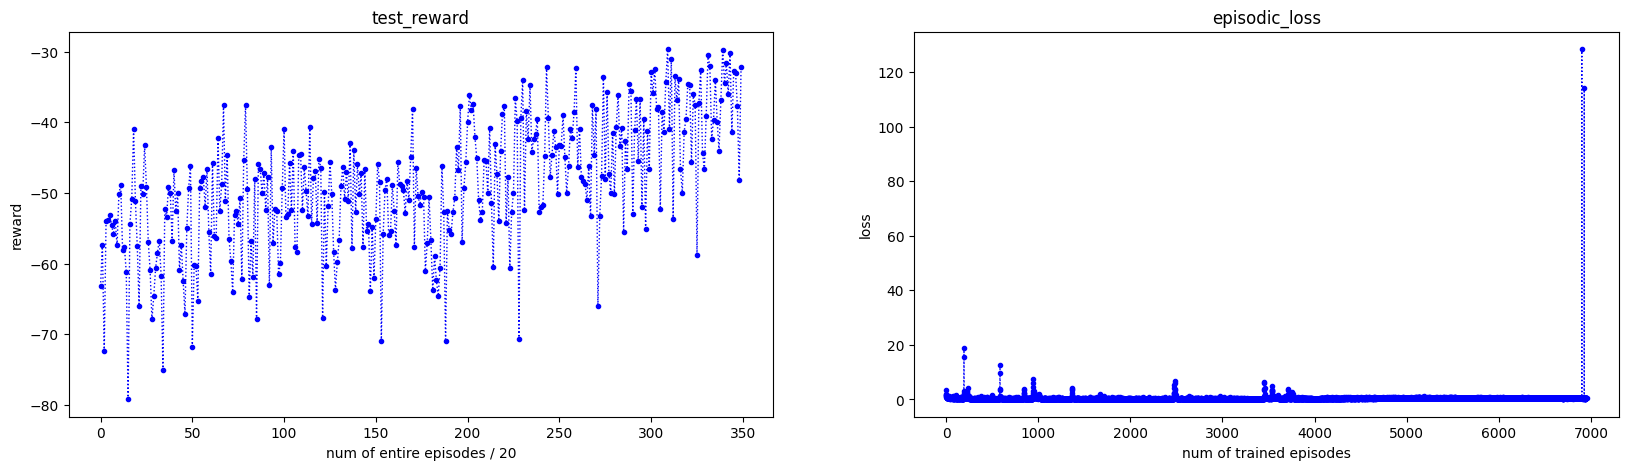

In [15]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,5))
ax1.plot(test_reward_list,'o:', markersize=3, color='blue', linewidth=1)
ax2.plot(episodic_loss_list,'o:', markersize=3, color='blue', linewidth=1)

ax1.set_title('test_reward')
ax2.set_title('episodic_loss')
ax1.set_xlabel('num of entire episodes / 20')
ax1.set_ylabel('reward')
ax2.set_xlabel('num of trained episodes')
ax2.set_ylabel('loss')

plt.show()

In [16]:
# 한 번에 동영상 2개가 최대, 한 세션 안에서 함수 다시 실행시키면 에러는 안 나는데 동영상 안 만들어짐 더 보고 싶으면 세션 다시 시작 해야
test_and_render(2)

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/Training_Pusher_by_DQN/DQN/비디오/newcamera_target_network_5layer folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/drive/MyDrive/Training_Pusher_by_DQN/DQN/비디오/newcamera_target_network_5layer/rl-video-episode-0.mp4.
Moviepy - Writing video /content/drive/MyDrive/Training_Pusher_by_DQN/DQN/비디오/newcamera_target_network_5layer/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Training_Pusher_by_DQN/DQN/비디오/newcamera_target_network_5layer/rl-video-episode-0.mp4
total reward of the episode : -34.937
Counter({10: 67, 2: 15, 0: 5, 7: 4, 5: 4, 6: 3, 8: 2})
Moviepy - Building video /content/drive/MyDrive/Training_Pusher_by_DQN/DQN/비디오/newcamera_target_network_5layer/rl-video-episode-1.mp4.
Moviepy - Writing video /content/drive/MyDrive/Training_Pusher_by_DQN/DQN/비디오/newcamera_target_network_5layer/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Training_Pusher_by_DQN/DQN/비디오/newcamera_target_network_5layer/rl-video-episode-1.mp4
total reward of the episode : -31.312
Counter({10: 61, 2: 14, 0: 7, 7: 5, 5: 4, 6: 4, 8: 3, 13: 2})


In [20]:
# 위에서 녹화한 결과를 띄움
# 두번째 동영상을 보고 싶으면 video_path의 0을 1로

from IPython.display import HTML
from base64 import b64encode
# episode 0 또는 1로
video_path = '비디오/newcamera_target_network_5layer/rl-video-episode-1.mp4'

mp4 = open(video_path,'rb').read()
decoded_vid = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'<video width=400 controls><source src={decoded_vid} type="video/mp4"></video>')